## Imports

In [1]:
import sys
import os
import argparse
import time
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from scipy.special import logsumexp
from scipy.io import arff

from sklearn import preprocessing
from sktime.utils.load_data import load_from_tsfile_to_dataframe

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tensorboardX import SummaryWriter


from utils import kNN, AverageMeter, py_softmax

In [2]:
ds_path = 'PenDigits/PenDigits'
label_enc = True
dims_num = 2
num_classes = 10
magic_dim = 256 # classifier_dim

## Training parameters

In [3]:
#data
datadir = "/root/data/Multivariate_ts"

# optimization
lamb = 10      # SK lambda-parameter
nopts = 400    # number of SK-optimizations
epochs = 400   # numbers of epochs
momentum = 0.9 # sgd momentum
exp = './lstm_exp' # experiments results dir


# other
devc='1'  # cuda device
batch_size = 500
lr=0.1     #learning rate
alr=0.9    #starting learning rate

knn_dim = 10
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [4]:
device = torch.device('cuda:' + devc) if torch.cuda.is_available() else torch.device('cpu')
print(f"GPU device: {device}")

GPU device: cuda:1


## Model parameters

In [5]:
hc=10       # number of heads
ncl=num_classes       # number of clusters

numc = [ncl] * hc
# numc = np.linspace(10, 1000, hc, dtype=np.int)

## Data Preparation

In [6]:
def preproc(X, dims_num):
    X = X.applymap(np.array)
    cols_lst = X.columns
    
    for col_name in cols_lst:
        dimension_values = np.dstack(list(X[col_name].values))[0].T
        time_steps_num = dimension_values.shape[1]
        
        for i in range(time_steps_num):
            one_step_values = dimension_values[:, i]
            X[col_name + f'_{i}'] = one_step_values
    
    X = X.drop(columns=cols_lst)
    
    step = int(X.shape[1] / dims_num)
    X_3d = []
    init = 0
    for dim_num in range(dims_num):
        X_3d.append(X.iloc[:, init:init + step])
        init += step
    X_3d = np.dstack(X_3d)
    return X_3d

def load_file(filepath, dims_num, is_arff=False):
    if is_arff:
        data = arff.loadarff(filepath) 
        data = pd.DataFrame(data[0])
        X = data.iloc[:, :-1] # [30, 65] x 4 times
        y = data.iloc[:, -1]
        return X.values, y.values
    else:
        X, y = load_from_tsfile_to_dataframe(filepath)
        X = preproc(X, dims_num)
        return X, y

def load_group(prefix, filenames, dims_num, is_arff=False):
    loaded = []
    if is_arff:
        for name in filenames: 
            X, y = load_file(prefix + "/" + name, dims_num, is_arff=is_arff) # [30, 65]
            loaded.append(X)
            # stack group so that features are the 3rd dimension 
        loaded = np.dstack(loaded) # [30, 65, 4]
    else:
        loaded, y = load_file(prefix + "/" + filenames[0], dims_num, is_arff=is_arff) # [30, 65, 4]
    return loaded, y

def load_dataset_group(folder_path, ds_path, dims_num, is_train=True, label_enc=False, is_arff=False): 
    filenames = []
    extension = ".arff" if is_arff else ".ts"
    postfix = "_TRAIN" if is_train else "_TEST"
    
    if is_arff:
        for dim_num in range(1, dims_num + 1):
            filenames.append(ds_path + str(dim_num) + postfix + extension)
    else:
        filenames.append(ds_path + postfix + extension)

    X, y = load_group(folder_path, filenames, dims_num, is_arff=is_arff) # [30, 65, 4]
    X = torch.from_numpy(np.array(X, dtype=np.float64))
    if label_enc:
        le = preprocessing.LabelEncoder()
        y = le.fit_transform(y)
        y = torch.from_numpy(np.array(y, dtype=np.int32))
    else:
        y = torch.from_numpy(np.array(y, dtype=np.int32)) - 1
    X = X.transpose(1, 2)
    return X, y

def load_dataset(folder_path, ds_path, dims_num, label_enc=False, is_arff=False): 
    X_train, y_train = load_dataset_group(folder_path, ds_path, dims_num, 
                                          is_train=True, label_enc=label_enc, is_arff=is_arff) 
    X_test, y_test = load_dataset_group(folder_path, ds_path, dims_num, 
                                        is_train=False, label_enc=label_enc, is_arff=is_arff) 
    return X_train, y_train, X_test, y_test

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt], excerpt

In [7]:
X_train, y_train, X_test, y_test = load_dataset(datadir, ds_path, dims_num, label_enc=label_enc, is_arff=False)
print("X_train.shape:", X_train.shape, "\ny_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape, "\ny_test.shape:", y_test.shape)

X_train.shape: torch.Size([7494, 2, 8]) 
y_train.shape: torch.Size([7494])
X_test.shape: torch.Size([3498, 2, 8]) 
y_test.shape: torch.Size([3498])


In [8]:
N = X_train.shape[0]
print('train size:', N)

train size: 7494


## Model, LSTM

In [9]:
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
class Normalize(nn.Module):
    def __init__(self, power=2):
        super(Normalize, self).__init__()
        self.power = power

    def forward(self, x):
        norm = x.pow(self.power).sum(1, keepdim=True).pow(1. / self.power)
        out = x.div(norm)
        return out

In [11]:
class LSTMFeatures(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, lstm_dropout=0.0):
        super(LSTMFeatures, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm_dropout = lstm_dropout
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=lstm_dropout)
    
    def forward(self, x):
        x = x.permute(2, 0, 1)
        batch_size = x.shape[1]
        hidden = (torch.rand(self.num_layers, batch_size, self.hidden_size, device=device),
                  torch.rand(self.num_layers, batch_size, self.hidden_size, device=device))
        out, hidden = self.lstm(x, hidden)
        return out, hidden

class LSTMClassifier(nn.Module):
    def __init__(self, lstm_features, hidden_size, num_classes, classifier_dim=256):
        super(LSTMClassifier, self).__init__()
        self.lstm_features = lstm_features
        self.num_classes = num_classes
        self.classifier = nn.Sequential(nn.Dropout(0.5),
                            nn.Linear(hidden_size, classifier_dim),
                            nn.ReLU(inplace=True),
                            nn.Dropout(0.5),
                            nn.Linear(classifier_dim, classifier_dim),
                            nn.ReLU(inplace=True))
        self.top_layer = nn.Linear(classifier_dim, num_classes)
    
    def forward(self, x):
        out, hidden = self.lstm_features(x)
        out = self.classifier(out[-1])
        out = self.top_layer(out)
        return out

class LSTMMultiHeadClassifier(nn.Module):
    def __init__(self, lstm_features, hidden_size, num_classes, classifier_dim=256):
        super(LSTMMultiHeadClassifier, self).__init__()
        self.lstm_features = lstm_features
        self.classifier = nn.Sequential(
                            nn.BatchNorm1d(hidden_size),
                            nn.Dropout(0.5),
                            nn.Linear(hidden_size, classifier_dim),
                            nn.BatchNorm1d(classifier_dim),
                            nn.ReLU(inplace=True),
                            nn.Dropout(0.5),
                            nn.Linear(classifier_dim, classifier_dim),
                            nn.ReLU(inplace=True))
        self.num_classes = num_classes
        self.headcount = len(num_classes)
        self.return_features = False
        if len(num_classes) == 1:
            self.top_layer = nn.Linear(classifier_dim, num_classes[0])
        else:
            for a, i in enumerate(num_classes):
                setattr(self, "top_layer%d" % a, nn.Linear(classifier_dim, i))
            self.top_layer = None  # this way headcount can act as switch.
    
    def forward(self, x):
        out, hidden = self.lstm_features(x)
        x = out[-1]
        if self.return_features:
            return x
        x = self.classifier(x)
        if self.headcount == 1:
            if self.top_layer: # this way headcount can act as switch.
                x = self.top_layer(x)
            return x
        else:
            outp = []
            for i in range(self.headcount):
                outp.append(getattr(self, "top_layer%d" % i)(x))
            return outp

## Dataloader

In [12]:
class MyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        super(MyDataset, self).__init__()
        self.X = X.float()
        self.y = y.long()
        self.transform = transform
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        if self.transform is not None:
            x = self.transform(x)
        return x, y

## Train supervised

In [13]:
def run_epoch(epoch, net, optimizer, criterion, dataloader, losses):
    net.to(device)
    net.train()
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        pred = net(X)
        loss = criterion(pred, y)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def evaluate_net(net, criterion, dataloader):
    total_loss = 0
    total_count = 0
    preds = []
    ys = []
    net.to(device)
    net.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = net(X)
            loss = criterion(pred, y) * y.shape[0]
            total_loss += loss.item()
            total_count += y.shape[0]
            preds.append(torch.argmax(pred, dim=1))
            ys.append(y)
    preds = torch.cat(preds)
    ys = torch.cat(ys)
    accuracy = (preds == ys).sum().item() / ys.shape[0]
    return total_loss / total_count, accuracy, preds, ys

In [14]:
dataset_train = MyDataset(X_train, y_train, transform=None)
dataloader_train = DataLoader(dataset_train, batch_size, shuffle=True)
dataset_test = MyDataset(X_test, y_test, transform=None)
dataloader_test = DataLoader(dataset_test, batch_size, shuffle=True)

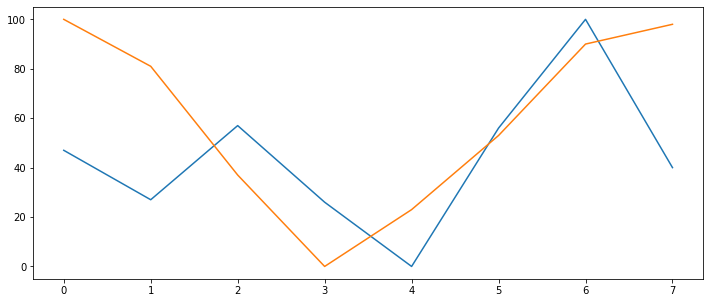

In [15]:
plt.figure(figsize=(12, 5))
sample = dataset_train[0][0]
for i in range(dims_num):
    plt.plot(sample[i])
plt.show()

In [16]:
features = LSTMFeatures(dims_num, 16 * dims_num, 4, lstm_dropout=0.0)
net = LSTMClassifier(features, 16 * dims_num, num_classes)
criterion = nn.CrossEntropyLoss()
losses = []
test_losses = []
test_iters = []
test_accuracies = []

In [17]:
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=5e-4)

In [18]:
loss, acc, _, _ = evaluate_net(net, criterion, dataloader_test)
print('test loss:', loss, 'test accuracy:', acc)

test loss: 2.3026126536592337 test accuracy: 0.10377358490566038


In [19]:
# for epoch in range(epochs):
#     print('epoch:', epoch)
#     run_epoch(epoch, net, optimizer, criterion, dataloader_train, losses)
#     loss, acc, _, _ = evaluate_net(net, criterion, dataloader_test)
#     clear_output()
#     plt.title('train and test losses')
#     plt.plot(losses)
#     test_losses.append(loss)
#     test_accuracies.append(acc)
#     test_iters.append(len(losses))
#     plt.plot(test_iters, test_losses)
#     plt.show()
#     plt.title('test accuracy')
#     plt.plot(test_iters, test_accuracies)
#     plt.show()
#     print('test loss:', loss, 'test accuracy:', acc)

## Sinkhorn-Knopp optimization

In [20]:
def optimize_L_sk(PS):
    N, K = PS.shape
    tt = time.time()
    PS = PS.T  # now it is K x N
    r = np.ones((K, 1)) / K
    c = np.ones((N, 1)) / N
    PS **= lamb  # K x N
    inv_K = 1. / K
    inv_N = 1. / N
    err = 1e3
    _counter = 0
    while err > 1e-2:
        r = inv_K / (PS @ c)  # (KxN)@(N,1) = K x 1
        c_new = inv_N / (r.T @ PS).T  # ((1,K)@(KxN)).t() = N x 1
        if _counter % 10 == 0:
            err = np.nansum(np.abs(c / c_new - 1))
        c = c_new
        _counter += 1
        
    print("error: ", err, 'step ', _counter, flush=True)  # " nonneg: ", sum(I), flush=True)
    # inplace calculations.
    PS *= np.squeeze(c)
    PS = PS.T
    PS *= np.squeeze(r)
    PS = PS.T
    argmaxes = np.nanargmax(PS, 0)  # size N
    newL = torch.LongTensor(argmaxes)
    selflabels = newL.to(device)
    PS = PS.T
    PS /= np.squeeze(r)
    PS = PS.T
    PS /= np.squeeze(c)
    sol = PS[argmaxes, np.arange(N)]
    np.log(sol, sol)
    cost = -(1. / lamb) * np.nansum(sol) / N
    print('cost: ', cost, flush=True)
    print('opt took {0:.2f}min, {1:4d}iters'.format(((time.time() - tt) / 60.), _counter), flush=True)
    return cost, selflabels

def opt_sk(model, selflabels_in, epoch):
    if hc == 1:
        PS = np.zeros((N, ncl))
    else:
        PS_pre = np.zeros((N, magic_dim)) # knn_dim
    
    for batch_idx, (data, _, _selected) in enumerate(iterate_minibatches(X_train, y_train, batch_size, shuffle=True)):
        data = data.to(device)#cuda()
        if hc == 1:
            p = nn.functional.softmax(model(data), 1)
            PS[_selected, :] = p.detach().cpu().numpy()
        else:
            p = model(data.float())
            PS_pre[_selected, :] = p.detach().cpu().numpy()
    if hc == 1:
        cost, selflabels = optimize_L_sk(PS)
        _costs = [cost]
    else:
        _nmis = np.zeros(hc)
        _costs = np.zeros(hc)
        nh = epoch % hc  # np.random.randint(args.hc)
        print("computing head %s " % nh, end="\r", flush=True)
        tl = getattr(model, "top_layer%d" % nh)
        # do the forward pass:
        PS = (PS_pre @ tl.weight.cpu().numpy().T
                   + tl.bias.cpu().numpy())
        PS = py_softmax(PS, 1)
        c, selflabels_ = optimize_L_sk(PS)
        _costs[nh] = c
        selflabels_in[nh] = selflabels_
        selflabels = selflabels_in
    return selflabels

## Training utils

In [21]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = alr
    if epochs == 200:
        if epoch >= 80:
            lr = alr * (0.1 ** ((epoch - 80) // 40))  # i.e. 120, 160
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    elif epochs == 400:
        if epoch >= 160:
            lr = alr * (0.1 ** ((epoch - 160) // 80))  # i.e. 240,320
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    elif epochs == 800:
        if epoch >= 320:
            lr = alr * (0.1 ** ((epoch - 320) // 160))  # i.e. 480, 640
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    elif epochs == 1600:
        if epoch >= 640:
            lr = alr * (0.1 ** ((epoch - 640) // 320))
            print(lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

In [22]:
def feature_return_switch(model, bool=True):
    """
    switch between network output or conv5features
        if True: changes switch s.t. forward pass returns post-conv5 features
        if False: changes switch s.t. forward will give full network output
    """
    if bool:
        model.headcount = 1
    else:
        model.headcount = hc
    model.return_feature = bool

In [23]:
def train(epoch, selflabels):
    print('\nEpoch: %d' % epoch)
    print(name)
    adjust_learning_rate(optimizer, epoch)
    train_loss = AverageMeter()
    data_time = AverageMeter()
    batch_time = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    
    for batch_idx, (inputs, targets, indexes) in enumerate(iterate_minibatches(X_train, y_train, batch_size, shuffle=True)):
        inputs = inputs.float().to(device)
        niter = epoch * N/batch_size + batch_idx
        if niter * batch_size >= optimize_times[-1]:
            with torch.no_grad():
                _ = optimize_times.pop()
                if hc >1:
                    feature_return_switch(model, True)
                selflabels = opt_sk(model, selflabels, epoch)
                if hc >1:
                    feature_return_switch(model, False)
        data_time.update(time.time() - end)
        inputs, targets = inputs.to(device), targets.to(device)#, indexes.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        if hc == 1:
            loss = criterion(outputs, selflabels[indexes])
        else:
            loss = torch.mean(torch.stack([criterion(outputs[h],
                                                     selflabels[h, indexes]) for h in range(hc)]))

        loss.backward()
        optimizer.step()

        train_loss.update(loss.item(), inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
#         if True:
        if batch_idx % 10 == 0:
            print('Epoch: [{}][{}/{}]'
                  'Time: {batch_time.val:.3f} ({batch_time.avg:.3f}) '
                  'Data: {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Loss: {train_loss.val:.4f} ({train_loss.avg:.4f})'.format(
                epoch, batch_idx, N/batch_size, batch_time=batch_time, data_time=data_time, train_loss=train_loss))
#             writer.add_scalar("loss", loss.item(), batch_idx*512 +epoch*N/batch_size)
    return selflabels

## Model initialization

In [24]:
features = LSTMFeatures(dims_num, 16 * dims_num, 4, lstm_dropout=0.0)
model = LSTMMultiHeadClassifier(features, 16 * dims_num, numc)

In [25]:
optimize_times = ((epochs + 1.0001)*N*(np.linspace(0, 1, nopts))[::-1]).tolist()
optimize_times = [(epochs +10)*N] + optimize_times
print('We will optimize L at epochs:', [np.round(1.0*t/N, 2) for t in optimize_times], flush=True)

We will optimize L at epochs: [410.0, 401.0, 400.0, 398.99, 397.99, 396.98, 395.98, 394.97, 393.97, 392.96, 391.95, 390.95, 389.94, 388.94, 387.93, 386.93, 385.92, 384.92, 383.91, 382.91, 381.9, 380.9, 379.89, 378.89, 377.88, 376.88, 375.87, 374.87, 373.86, 372.86, 371.85, 370.85, 369.84, 368.84, 367.83, 366.83, 365.82, 364.82, 363.81, 362.81, 361.8, 360.8, 359.79, 358.79, 357.78, 356.78, 355.77, 354.77, 353.76, 352.76, 351.75, 350.75, 349.74, 348.74, 347.73, 346.73, 345.72, 344.72, 343.71, 342.71, 341.7, 340.7, 339.69, 338.69, 337.68, 336.68, 335.67, 334.67, 333.66, 332.66, 331.65, 330.65, 329.64, 328.64, 327.63, 326.63, 325.62, 324.62, 323.61, 322.61, 321.6, 320.6, 319.59, 318.59, 317.58, 316.58, 315.57, 314.57, 313.56, 312.56, 311.55, 310.55, 309.54, 308.54, 307.53, 306.53, 305.52, 304.52, 303.51, 302.51, 301.5, 300.5, 299.49, 298.49, 297.48, 296.48, 295.47, 294.47, 293.46, 292.46, 291.45, 290.45, 289.44, 288.44, 287.43, 286.43, 285.42, 284.42, 283.41, 282.41, 281.4, 280.4, 279.39, 

In [26]:
# init selflabels randomly
if hc == 1:
    selflabels = np.zeros(N, dtype=np.int32)
    for qq in range(N):
        selflabels[qq] = qq % ncl
    selflabels = np.random.permutation(selflabels)
    selflabels = torch.LongTensor(selflabels).to(device)
else:
    selflabels = np.zeros((hc, N), dtype=np.int32)
    for nh in range(hc):
        for _i in range(N):
            selflabels[nh, _i] = _i % numc[nh]
        selflabels[nh] = np.random.permutation(selflabels[nh])
    selflabels = torch.LongTensor(selflabels).to(device)

In [27]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=5e-4)
model.to(device)
criterion = nn.CrossEntropyLoss()

In [28]:
name = "LSTM"
writer = SummaryWriter(f'./runs/pendigits/{name}')

## Training! 
Takes a couple of minutes per epoch

In [29]:
def my_kNN(net, K, sigma=0.1, dim=128, use_pca=False):
    net.eval()
    # this part is ugly but made to be backwards-compatible. there was a change in cifar dataset's structure.
    trainLabels = y_train
    LEN = N
    C = trainLabels.max() + 1

    trainFeatures = torch.zeros((magic_dim, LEN))  # , device='cuda:0') # dim
    normalize = Normalize()
    normalize.to(device)
    for batch_idx, (inputs, targets, _) in enumerate(iterate_minibatches(X_train, y_train, batch_size, shuffle=False)):
        batchSize = batch_size
        inputs = inputs.to(device)
        features = net(inputs.float())
        if not use_pca:
            features = normalize(features)
        tmp = trainFeatures[:, batch_idx * batchSize:batch_idx * batchSize + batchSize]
        trainFeatures[:, batch_idx * batchSize:batch_idx * batchSize + batchSize] = features.data.t().cpu()
        
    if use_pca:
        comps = dim
        print('doing PCA with %s components'%comps, end=' ')
        from sklearn.decomposition import PCA
        pca = PCA(n_components=comps, whiten=False)
        trainFeatures = pca.fit_transform(trainFeatures.numpy().T)
        trainFeatures = torch.Tensor(trainFeatures).to(device)
        trainFeatures = normalize(trainFeatures).t().cpu()
        print('..done')
    def eval_k_s(K_,sigma_):
        total = 0
        top1 = 0.
#         top5 = 0.

        with torch.no_grad():
            retrieval_one_hot = torch.zeros(K_, C)# .cuda()
            for batch_idx, (inputs, targets, _) in enumerate(iterate_minibatches(X_test, y_test, batch_size, shuffle=False)):
                targets = targets # .cuda(async=True) # or without async for py3.7
                inputs = inputs.to(device)
                batchSize = batch_size
                features = net(inputs.float())
                if use_pca:
                    features = pca.transform(features.cpu().numpy())
                    features = torch.Tensor(features).to(device)
                features = normalize(features).cpu()

                dist = torch.mm(features, trainFeatures)

                yd, yi = dist.topk(K_, dim=1, largest=True, sorted=True)
                candidates = trainLabels.view(1, -1).expand(batchSize, -1)
                retrieval = torch.gather(candidates, 1, yi).long()

                retrieval_one_hot.resize_(batchSize * K_, C).zero_()
                retrieval_one_hot.scatter_(1, retrieval.view(-1, 1), 1.)
                
                yd_transform = yd.clone().div_(sigma_).exp_()
                probs = torch.sum(torch.mul(retrieval_one_hot.view(batchSize, -1, C),
                                            yd_transform.view(batchSize, -1, 1)),
                                  1)
                _, predictions = probs.sort(1, True)

                # Find which predictions match the target
                correct = predictions.eq(targets.data.view(-1, 1))

                top1 = top1 + correct.narrow(1, 0, 1).sum().item()
#                 top5 = top5 + correct.narrow(1, 0, 5).sum().item()

                total += targets.size(0)

        print(f"{K_}-NN,s={sigma_}: TOP1: ", top1 * 100. / total)
        return top1 / total

    if isinstance(K, list):
        res = []
        for K_ in K:
            for sigma_ in sigma:
                res.append(eval_k_s(K_, sigma_))
        return res
    else:
        res = eval_k_s(K, sigma)
        return res

In [30]:
import time

start = time.time()
for epoch in range(start_epoch, start_epoch + epochs):
    selflabels = train(epoch, selflabels)
    feature_return_switch(model, True)
    
    acc = my_kNN(model, K=10, sigma=0.1, dim=knn_dim)
    feature_return_switch(model, False)
#     writer.add_scalar("accuracy kNN", acc, epoch)
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'opt': optimizer.state_dict(),
            'L': selflabels,
        }
        if not os.path.isdir(exp):
            os.mkdir(exp)
        torch.save(state, '%s/best_ckpt.t7' % (exp))
        best_acc = acc
    if epoch % 100 == 0:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'opt': optimizer.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'L': selflabels,
        }
        if not os.path.isdir(exp):
            os.mkdir(exp)
        torch.save(state, '%s/ep%s.t7' % (exp, epoch))
    if epoch % 50 == 0:
        feature_return_switch(model, True)
        acc = my_kNN(model, K=[50, 10], sigma=[0.1, 0.5], dim=knn_dim, use_pca=True)
        i = 0
#         for num_nn in [50, 10]:
#             for sig in [0.1, 0.5]:
#                 writer.add_scalar('knn%s-%s' % (num_nn, sig), acc[i], epoch)
#                 i += 1
        feature_return_switch(model, False)
    print('best accuracy: {:.2f}'.format(best_acc * 100))
end = time.time()

checkpoint = torch.load('%s'%exp+'/best_ckpt.t7' )
model.load_state_dict(checkpoint['net'])
feature_return_switch(model, True)
acc = my_kNN(model, K=10, sigma=0.1, dim=knn_dim, use_pca=True)


Epoch: 0
LSTM
error:  5.840405971069274e-07 step  21
cost:  2.0644587053760888
opt took 0.00min,   21iters
Epoch: [0][0/14.988]Time: 0.396 (0.396) Data: 0.334 (0.334) Loss: 2.3307 (2.3307)
Epoch: [0][10/14.988]Time: 0.014 (0.051) Data: 0.001 (0.031) Loss: 2.3105 (2.3169)
10-NN,s=0.1: TOP1:  27.4
Saving..
Saving..
doing PCA with 10 components ..done
50-NN,s=0.1: TOP1:  26.9
50-NN,s=0.5: TOP1:  27.766666666666666
10-NN,s=0.1: TOP1:  24.766666666666666
10-NN,s=0.5: TOP1:  23.4
best accuracy: 27.40

Epoch: 1
LSTM
Epoch: [1][0/14.988]Time: 0.025 (0.025) Data: 0.004 (0.004) Loss: 2.3053 (2.3053)
error:  2.8981607114175745e-09 step  11
cost:  2.2061343142566314
opt took 0.00min,   11iters
Epoch: [1][10/14.988]Time: 0.014 (0.033) Data: 0.002 (0.017) Loss: 2.2985 (2.3030)
10-NN,s=0.1: TOP1:  27.733333333333334
Saving..
best accuracy: 27.73

Epoch: 2
LSTM
Epoch: [2][0/14.988]Time: 0.017 (0.017) Data: 0.001 (0.001) Loss: 2.2991 (2.2991)
error:  7.986944439153376e-13 step  11
cost:  2.24855155528

error:  0.008363911712195526 step  271
cost:  0.8741472291597109
opt took 0.00min,  271iters
Epoch: [24][10/14.988]Time: 0.015 (0.047) Data: 0.001 (0.032) Loss: 1.1647 (1.1696)
10-NN,s=0.1: TOP1:  54.766666666666666
Saving..
best accuracy: 54.77

Epoch: 25
LSTM
Epoch: [25][0/14.988]Time: 0.016 (0.016) Data: 0.002 (0.002) Loss: 1.2367 (1.2367)
error:  0.007412689448982435 step  281
cost:  0.9403128305385614
opt took 0.00min,  281iters
Epoch: [25][10/14.988]Time: 0.017 (0.038) Data: 0.001 (0.018) Loss: 1.1301 (1.1963)
10-NN,s=0.1: TOP1:  51.766666666666666
best accuracy: 54.77

Epoch: 26
LSTM
Epoch: [26][0/14.988]Time: 0.015 (0.015) Data: 0.001 (0.001) Loss: 1.1051 (1.1051)
error:  0.009186758990635702 step  321
cost:  0.8559262571843768
opt took 0.00min,  321iters
Epoch: [26][10/14.988]Time: 0.015 (0.046) Data: 0.001 (0.027) Loss: 1.1381 (1.1105)
10-NN,s=0.1: TOP1:  50.5
best accuracy: 54.77

Epoch: 27
LSTM
Epoch: [27][0/14.988]Time: 0.016 (0.016) Data: 0.001 (0.001) Loss: 1.1218 (1.121

error:  0.009403687783453796 step  471
cost:  0.6223744331517991
opt took 0.00min,  471iters
Epoch: [49][10/14.988]Time: 0.019 (0.050) Data: 0.001 (0.030) Loss: 0.9417 (0.9811)
10-NN,s=0.1: TOP1:  56.333333333333336
best accuracy: 60.80

Epoch: 50
LSTM
Epoch: [50][0/14.988]Time: 0.017 (0.017) Data: 0.002 (0.002) Loss: 0.9132 (0.9132)
error:  0.009544959990712587 step  401
cost:  0.626328328342588
opt took 0.00min,  401iters
Epoch: [50][10/14.988]Time: 0.017 (0.031) Data: 0.001 (0.012) Loss: 0.9941 (0.9960)
10-NN,s=0.1: TOP1:  59.63333333333333
doing PCA with 10 components ..done
50-NN,s=0.1: TOP1:  56.06666666666667
50-NN,s=0.5: TOP1:  56.666666666666664
10-NN,s=0.1: TOP1:  59.3
10-NN,s=0.5: TOP1:  60.43333333333333
best accuracy: 60.80

Epoch: 51
LSTM
Epoch: [51][0/14.988]Time: 0.015 (0.015) Data: 0.001 (0.001) Loss: 0.9473 (0.9473)
error:  0.009248435786569309 step  691
cost:  0.6192385576215909
opt took 0.01min,  691iters
Epoch: [51][10/14.988]Time: 0.015 (0.071) Data: 0.001 (0.056)

opt took 0.00min,  321iters
Epoch: [73][10/14.988]Time: 0.020 (0.033) Data: 0.001 (0.018) Loss: 0.9217 (0.9431)
10-NN,s=0.1: TOP1:  61.266666666666666
best accuracy: 63.90

Epoch: 74
LSTM
Epoch: [74][0/14.988]Time: 0.012 (0.012) Data: 0.001 (0.001) Loss: 0.9093 (0.9093)
error:  0.009101520021954856 step  691
cost:  0.5840362440897935
opt took 0.00min,  691iters
Epoch: [74][10/14.988]Time: 0.015 (0.028) Data: 0.001 (0.015) Loss: 0.9536 (0.9668)
10-NN,s=0.1: TOP1:  61.86666666666667
best accuracy: 63.90

Epoch: 75
LSTM
Epoch: [75][0/14.988]Time: 0.012 (0.012) Data: 0.002 (0.002) Loss: 1.0090 (1.0090)
error:  0.008333232159520532 step  601
cost:  0.6911106684093993
opt took 0.00min,  601iters
Epoch: [75][10/14.988]Time: 0.025 (0.027) Data: 0.001 (0.012) Loss: 0.9631 (0.9765)
10-NN,s=0.1: TOP1:  61.233333333333334
best accuracy: 63.90

Epoch: 76
LSTM
Epoch: [76][0/14.988]Time: 0.012 (0.012) Data: 0.001 (0.001) Loss: 0.8759 (0.8759)
error:  0.009436261938215007 step  411
cost:  0.5872780324

error:  0.009111917434368122 step  431
cost:  0.6394009241333213
opt took 0.00min,  431iters
Epoch: [98][10/14.988]Time: 0.015 (0.026) Data: 0.001 (0.014) Loss: 0.9037 (0.8794)
10-NN,s=0.1: TOP1:  59.63333333333333
best accuracy: 64.10

Epoch: 99
LSTM
Epoch: [99][0/14.988]Time: 0.015 (0.015) Data: 0.001 (0.001) Loss: 0.8679 (0.8679)
error:  0.008601701700504893 step  591
cost:  0.5657812505042379
opt took 0.00min,  591iters
Epoch: [99][10/14.988]Time: 0.017 (0.034) Data: 0.001 (0.020) Loss: 0.8673 (0.8687)
10-NN,s=0.1: TOP1:  64.9
Saving..
best accuracy: 64.90

Epoch: 100
LSTM
Epoch: [100][0/14.988]Time: 0.014 (0.014) Data: 0.001 (0.001) Loss: 0.8809 (0.8809)
error:  0.00736219972460439 step  281
cost:  0.5682788255629369
opt took 0.00min,  281iters
Epoch: [100][10/14.988]Time: 0.017 (0.025) Data: 0.001 (0.010) Loss: 0.8245 (0.8663)
10-NN,s=0.1: TOP1:  62.03333333333333
Saving..
doing PCA with 10 components ..done
50-NN,s=0.1: TOP1:  58.9
50-NN,s=0.5: TOP1:  58.833333333333336
10-NN,s=

error:  0.009891888694305906 step  531
cost:  0.5955727131515733
opt took 0.00min,  531iters
Epoch: [122][10/14.988]Time: 0.256 (0.034) Data: 0.234 (0.022) Loss: 0.8864 (0.9109)
10-NN,s=0.1: TOP1:  62.733333333333334
best accuracy: 65.60

Epoch: 123
LSTM
Epoch: [123][0/14.988]Time: 0.012 (0.012) Data: 0.001 (0.001) Loss: 0.8294 (0.8294)
error:  0.008686043543944977 step  671
cost:  0.561113648620798
opt took 0.00min,  671iters
Epoch: [123][10/14.988]Time: 0.158 (0.024) Data: 0.144 (0.014) Loss: 0.8362 (0.8547)
10-NN,s=0.1: TOP1:  63.56666666666667
best accuracy: 65.60

Epoch: 124
LSTM
Epoch: [124][0/14.988]Time: 0.012 (0.012) Data: 0.001 (0.001) Loss: 0.8673 (0.8673)
error:  0.008603465619176798 step  531
cost:  0.5340222903319344
opt took 0.00min,  531iters
Epoch: [124][10/14.988]Time: 0.142 (0.023) Data: 0.125 (0.012) Loss: 0.8941 (0.8402)
10-NN,s=0.1: TOP1:  62.7
best accuracy: 65.60

Epoch: 125
LSTM
Epoch: [125][0/14.988]Time: 0.014 (0.014) Data: 0.001 (0.001) Loss: 0.8661 (0.8661)

opt took 0.00min,  561iters
10-NN,s=0.1: TOP1:  65.1
best accuracy: 66.90

Epoch: 147
LSTM
Epoch: [147][0/14.988]Time: 0.020 (0.020) Data: 0.002 (0.002) Loss: 0.9524 (0.9524)
Epoch: [147][10/14.988]Time: 0.013 (0.017) Data: 0.001 (0.001) Loss: 0.7976 (0.8746)
error:  0.009087683621662568 step  631
cost:  0.5547169610358622
opt took 0.00min,  631iters
10-NN,s=0.1: TOP1:  69.36666666666666
Saving..
best accuracy: 69.37

Epoch: 148
LSTM
Epoch: [148][0/14.988]Time: 0.012 (0.012) Data: 0.001 (0.001) Loss: 0.8524 (0.8524)
Epoch: [148][10/14.988]Time: 0.011 (0.011) Data: 0.001 (0.001) Loss: 0.7910 (0.8264)
error:  0.00934539887109842 step  941
cost:  0.552168988401251
opt took 0.00min,  941iters
10-NN,s=0.1: TOP1:  69.16666666666667
best accuracy: 69.37

Epoch: 149
LSTM
Epoch: [149][0/14.988]Time: 0.019 (0.019) Data: 0.002 (0.002) Loss: 0.8156 (0.8156)
Epoch: [149][10/14.988]Time: 0.012 (0.014) Data: 0.000 (0.001) Loss: 0.8211 (0.8237)
error:  0.007404533125084378 step  331
cost:  0.531211572

opt took 0.01min, 1381iters
10-NN,s=0.1: TOP1:  69.96666666666667
best accuracy: 71.67

Epoch: 171
LSTM
0.9
Epoch: [171][0/14.988]Time: 0.013 (0.013) Data: 0.002 (0.002) Loss: 0.8462 (0.8462)
Epoch: [171][10/14.988]Time: 0.011 (0.011) Data: 0.001 (0.001) Loss: 0.7651 (0.7928)
error:  0.009784957910220382 step  621
cost:  0.4763268823591198
opt took 0.00min,  621iters
10-NN,s=0.1: TOP1:  69.83333333333333
best accuracy: 71.67

Epoch: 172
LSTM
0.9
Epoch: [172][0/14.988]Time: 0.013 (0.013) Data: 0.001 (0.001) Loss: 0.8123 (0.8123)
Epoch: [172][10/14.988]Time: 0.011 (0.012) Data: 0.000 (0.001) Loss: 0.7734 (0.7869)
error:  0.008884064103727995 step  491
cost:  0.5399695909686855
opt took 0.00min,  491iters
10-NN,s=0.1: TOP1:  69.3
best accuracy: 71.67

Epoch: 173
LSTM
0.9
Epoch: [173][0/14.988]Time: 0.013 (0.013) Data: 0.002 (0.002) Loss: 0.8024 (0.8024)
Epoch: [173][10/14.988]Time: 0.011 (0.012) Data: 0.000 (0.001) Loss: 0.8376 (0.7836)
error:  0.00952630521034925 step  871
cost:  0.56010

10-NN,s=0.1: TOP1:  68.43333333333334
best accuracy: 71.67

Epoch: 196
LSTM
0.9
error:  0.009666592202586699 step  401
cost:  0.5650159452925055
opt took 0.00min,  401iters
Epoch: [196][0/14.988]Time: 0.162 (0.162) Data: 0.146 (0.146) Loss: 0.7347 (0.7347)
Epoch: [196][10/14.988]Time: 0.011 (0.027) Data: 0.001 (0.014) Loss: 0.7196 (0.7642)
10-NN,s=0.1: TOP1:  67.03333333333333
best accuracy: 71.67

Epoch: 197
LSTM
0.9
error:  0.009641584899991673 step  611
cost:  0.5040234520126825
opt took 0.00min,  611iters
Epoch: [197][0/14.988]Time: 0.168 (0.168) Data: 0.154 (0.154) Loss: 0.7598 (0.7598)
Epoch: [197][10/14.988]Time: 0.010 (0.030) Data: 0.000 (0.015) Loss: 0.7623 (0.8064)
10-NN,s=0.1: TOP1:  70.23333333333333
best accuracy: 71.67

Epoch: 198
LSTM
0.9
error:  0.009445405445295707 step  621
cost:  0.5208551553379883
opt took 0.00min,  621iters
Epoch: [198][0/14.988]Time: 0.267 (0.267) Data: 0.251 (0.251) Loss: 0.8055 (0.8055)
Epoch: [198][10/14.988]Time: 0.011 (0.037) Data: 0.001 (0.0

10-NN,s=0.1: TOP1:  67.43333333333334
best accuracy: 71.67

Epoch: 220
LSTM
0.9
Epoch: [220][0/14.988]Time: 0.013 (0.013) Data: 0.001 (0.001) Loss: 0.7628 (0.7628)
error:  0.008796354968154674 step  611
cost:  0.45727562354201123
opt took 0.00min,  611iters
Epoch: [220][10/14.988]Time: 0.013 (0.030) Data: 0.000 (0.013) Loss: 0.7558 (0.7541)
10-NN,s=0.1: TOP1:  68.66666666666667
best accuracy: 71.67

Epoch: 221
LSTM
0.9
Epoch: [221][0/14.988]Time: 0.014 (0.014) Data: 0.002 (0.002) Loss: 0.7027 (0.7027)
error:  0.00996301011630818 step  861
cost:  0.5046845657668461
opt took 0.00min,  861iters
Epoch: [221][10/14.988]Time: 0.012 (0.034) Data: 0.000 (0.018) Loss: 0.8206 (0.8077)
10-NN,s=0.1: TOP1:  67.66666666666667
best accuracy: 71.67

Epoch: 222
LSTM
0.9
Epoch: [222][0/14.988]Time: 0.013 (0.013) Data: 0.002 (0.002) Loss: 0.7683 (0.7683)
error:  0.00983083116167316 step  981
cost:  0.5010545709295738
opt took 0.00min,  981iters
Epoch: [222][10/14.988]Time: 0.011 (0.032) Data: 0.001 (0.01

error:  0.009170316588970828 step  511
cost:  0.45488371749081025
opt took 0.00min,  511iters
Epoch: [244][10/14.988]Time: 0.011 (0.027) Data: 0.001 (0.014) Loss: 0.6631 (0.6608)
10-NN,s=0.1: TOP1:  67.93333333333334
best accuracy: 72.63

Epoch: 245
LSTM
0.09000000000000001
Epoch: [245][0/14.988]Time: 0.011 (0.011) Data: 0.001 (0.001) Loss: 0.6551 (0.6551)
error:  0.00894750823757906 step  791
cost:  0.4411364298962272
opt took 0.00min,  791iters
Epoch: [245][10/14.988]Time: 0.015 (0.025) Data: 0.001 (0.012) Loss: 0.6308 (0.6552)
10-NN,s=0.1: TOP1:  68.03333333333333
best accuracy: 72.63

Epoch: 246
LSTM
0.09000000000000001
Epoch: [246][0/14.988]Time: 0.014 (0.014) Data: 0.002 (0.002) Loss: 0.6481 (0.6481)
error:  0.009130500969193212 step  731
cost:  0.4319822898862079
opt took 0.00min,  731iters
Epoch: [246][10/14.988]Time: 0.014 (0.032) Data: 0.001 (0.017) Loss: 0.6468 (0.6410)
10-NN,s=0.1: TOP1:  68.6
best accuracy: 72.63

Epoch: 247
LSTM
0.09000000000000001
Epoch: [247][0/14.988]T

error:  0.009527304250717017 step  1121
cost:  0.3669254007246366
opt took 0.00min, 1121iters
Epoch: [267][10/14.988]Time: 0.012 (0.044) Data: 0.001 (0.028) Loss: 0.5072 (0.5398)
10-NN,s=0.1: TOP1:  67.6
best accuracy: 72.63

Epoch: 268
LSTM
0.09000000000000001
Epoch: [268][0/14.988]Time: 0.012 (0.012) Data: 0.001 (0.001) Loss: 0.5279 (0.5279)
error:  0.00936768268899102 step  1111
cost:  0.38771781997757887
opt took 0.01min, 1111iters
Epoch: [268][10/14.988]Time: 0.015 (0.068) Data: 0.001 (0.056) Loss: 0.5280 (0.5342)
10-NN,s=0.1: TOP1:  68.0
best accuracy: 72.63

Epoch: 269
LSTM
0.09000000000000001
Epoch: [269][0/14.988]Time: 0.012 (0.012) Data: 0.001 (0.001) Loss: 0.5477 (0.5477)
error:  0.009605736090084749 step  1211
cost:  0.38890495192265206
opt took 0.00min, 1211iters
Epoch: [269][10/14.988]Time: 0.021 (0.035) Data: 0.001 (0.020) Loss: 0.5749 (0.5506)
10-NN,s=0.1: TOP1:  66.56666666666666
best accuracy: 72.63

Epoch: 270
LSTM
0.09000000000000001
Epoch: [270][0/14.988]Time: 0.01

Epoch: [290][10/14.988]Time: 0.015 (0.031) Data: 0.001 (0.019) Loss: 0.5035 (0.4913)
10-NN,s=0.1: TOP1:  67.26666666666667
best accuracy: 72.63

Epoch: 291
LSTM
0.09000000000000001
Epoch: [291][0/14.988]Time: 0.012 (0.012) Data: 0.001 (0.001) Loss: 0.4547 (0.4547)
error:  0.009855417687183232 step  991
cost:  0.3462313543030362
opt took 0.01min,  991iters
Epoch: [291][10/14.988]Time: 0.024 (0.049) Data: 0.001 (0.035) Loss: 0.4815 (0.4894)
10-NN,s=0.1: TOP1:  66.46666666666667
best accuracy: 72.63

Epoch: 292
LSTM
0.09000000000000001
Epoch: [292][0/14.988]Time: 0.012 (0.012) Data: 0.001 (0.001) Loss: 0.4695 (0.4695)
error:  0.009389933380751558 step  1241
cost:  0.3690494854856009
opt took 0.01min, 1241iters
Epoch: [292][10/14.988]Time: 0.014 (0.074) Data: 0.001 (0.062) Loss: 0.5094 (0.5008)
10-NN,s=0.1: TOP1:  66.8
best accuracy: 72.63

Epoch: 293
LSTM
0.09000000000000001
Epoch: [293][0/14.988]Time: 0.012 (0.012) Data: 0.001 (0.001) Loss: 0.5133 (0.5133)
error:  0.009787596111992869 st

error:  0.009632503585377705 step  1191
cost:  0.41625810931946516
opt took 0.00min, 1191iters
Epoch: [313][10/14.988]Time: 0.015 (0.031) Data: 0.001 (0.020) Loss: 0.5314 (0.5181)
10-NN,s=0.1: TOP1:  68.26666666666667
best accuracy: 72.63

Epoch: 314
LSTM
0.09000000000000001
Epoch: [314][0/14.988]Time: 0.012 (0.012) Data: 0.001 (0.001) Loss: 0.5139 (0.5139)
error:  0.009686539710522357 step  1011
cost:  0.38084740670960276
opt took 0.00min, 1011iters
Epoch: [314][10/14.988]Time: 0.013 (0.032) Data: 0.001 (0.021) Loss: 0.5133 (0.5137)
10-NN,s=0.1: TOP1:  69.03333333333333
best accuracy: 72.63

Epoch: 315
LSTM
0.09000000000000001
Epoch: [315][0/14.988]Time: 0.011 (0.011) Data: 0.001 (0.001) Loss: 0.5029 (0.5029)
error:  0.009605959236276163 step  1101
cost:  0.3699347750352784
opt took 0.00min, 1101iters
Epoch: [315][10/14.988]Time: 0.014 (0.027) Data: 0.001 (0.016) Loss: 0.5174 (0.5076)
10-NN,s=0.1: TOP1:  67.63333333333334
best accuracy: 72.63

Epoch: 316
LSTM
0.09000000000000001
Epoch

error:  0.008916480132632465 step  481
cost:  0.3683167296925553
opt took 0.00min,  481iters
10-NN,s=0.1: TOP1:  68.5
best accuracy: 72.63

Epoch: 337
LSTM
0.009000000000000003
Epoch: [337][0/14.988]Time: 0.012 (0.012) Data: 0.001 (0.001) Loss: 0.4794 (0.4794)
Epoch: [337][10/14.988]Time: 0.012 (0.011) Data: 0.001 (0.001) Loss: 0.4793 (0.4677)
error:  0.009644612334796077 step  1721
cost:  0.3439784759372267
opt took 0.00min, 1721iters
10-NN,s=0.1: TOP1:  69.06666666666666
best accuracy: 72.63

Epoch: 338
LSTM
0.009000000000000003
Epoch: [338][0/14.988]Time: 0.012 (0.012) Data: 0.001 (0.001) Loss: 0.4914 (0.4914)
Epoch: [338][10/14.988]Time: 0.011 (0.011) Data: 0.000 (0.001) Loss: 0.4661 (0.4655)
error:  0.009905284909882517 step  1411
cost:  0.3375520214261208
opt took 0.01min, 1411iters
10-NN,s=0.1: TOP1:  68.86666666666666
best accuracy: 72.63

Epoch: 339
LSTM
0.009000000000000003
Epoch: [339][0/14.988]Time: 0.011 (0.011) Data: 0.001 (0.001) Loss: 0.4769 (0.4769)
Epoch: [339][10/14.

Epoch: [359][10/14.988]Time: 0.010 (0.010) Data: 0.000 (0.001) Loss: 0.4203 (0.4371)
error:  0.009995081383506688 step  1281
cost:  0.3646993879617299
opt took 0.00min, 1281iters
10-NN,s=0.1: TOP1:  69.66666666666667
best accuracy: 72.63

Epoch: 360
LSTM
0.009000000000000003
Epoch: [360][0/14.988]Time: 0.014 (0.014) Data: 0.001 (0.001) Loss: 0.4805 (0.4805)
Epoch: [360][10/14.988]Time: 0.012 (0.012) Data: 0.000 (0.001) Loss: 0.4496 (0.4615)
error:  0.009411621544060056 step  1221
cost:  0.3294104022657716
opt took 0.00min, 1221iters
10-NN,s=0.1: TOP1:  69.83333333333333
best accuracy: 72.63

Epoch: 361
LSTM
0.009000000000000003
Epoch: [361][0/14.988]Time: 0.012 (0.012) Data: 0.001 (0.001) Loss: 0.4604 (0.4604)
Epoch: [361][10/14.988]Time: 0.010 (0.011) Data: 0.000 (0.001) Loss: 0.4725 (0.4585)
error:  0.009978419995764543 step  1171
cost:  0.31841756085876116
opt took 0.00min, 1171iters
10-NN,s=0.1: TOP1:  69.56666666666666
best accuracy: 72.63

Epoch: 362
LSTM
0.009000000000000003
Epo

10-NN,s=0.1: TOP1:  69.53333333333333
best accuracy: 72.63

Epoch: 383
LSTM
0.009000000000000003
error:  0.009981997332011772 step  1221
cost:  0.3820953604380831
opt took 0.00min, 1221iters
Epoch: [383][0/14.988]Time: 0.270 (0.270) Data: 0.248 (0.248) Loss: 0.4505 (0.4505)
Epoch: [383][10/14.988]Time: 0.010 (0.037) Data: 0.000 (0.023) Loss: 0.4458 (0.4352)
10-NN,s=0.1: TOP1:  69.4
best accuracy: 72.63

Epoch: 384
LSTM
0.009000000000000003
error:  0.009464249658518553 step  1231
cost:  0.3347801202896538
opt took 0.00min, 1231iters
Epoch: [384][0/14.988]Time: 0.285 (0.285) Data: 0.269 (0.269) Loss: 0.4329 (0.4329)
Epoch: [384][10/14.988]Time: 0.011 (0.038) Data: 0.001 (0.025) Loss: 0.4268 (0.4328)
10-NN,s=0.1: TOP1:  69.6
best accuracy: 72.63

Epoch: 385
LSTM
0.009000000000000003
error:  0.00974768091776601 step  1121
cost:  0.3184830261821496
opt took 0.00min, 1121iters
Epoch: [385][0/14.988]Time: 0.242 (0.242) Data: 0.227 (0.227) Loss: 0.4243 (0.4243)
Epoch: [385][10/14.988]Time: 0.0